# **Requirement 1: Single product and stochastic environment**

In [3]:
import matplotlib.pyplot as plt
from pydantic import BaseModel
from typing import List
import numpy as np

ValueError: Key backend: 'module://matplotlib_inline.backend_inline' is not a valid value for backend; supported values are ['gtk3agg', 'gtk3cairo', 'gtk4agg', 'gtk4cairo', 'macosx', 'nbagg', 'notebook', 'qtagg', 'qtcairo', 'qt5agg', 'qt5cairo', 'tkagg', 'tkcairo', 'webagg', 'wx', 'wxagg', 'wxcairo', 'agg', 'cairo', 'pdf', 'pgf', 'ps', 'svg', 'template']

## Environmnet

**Build a stochastic environment:**
    
    - A distribution over the valuations of a single type of product

**Design algorithms for a single product and stochastic environment:**
    
    - Algorithm n1: 
        Build a pricing strategy using UCB1 ignoring the inventory constraint.
    
    - Algorithm n2: 
        Build a pricing strategy extending UCB1 to handle the inventory constraint.
    
    - Hint: 
        Extend the “UCB-like” approach that we saw for auctions to the pricing problem.

In [3]:
class Environment:
    def __init__(self):
        pass

    def round(self, a_t):
        pass

In [ ]:
class Parameters(BaseModel):
    number_of_rounds: int
    number_of_products: int
    possible_prices: List[float]
    production_capacity: int

parameters = Parameters(number_of_rounds=100, 
                        number_of_products=1, 
                        possible_prices=[10, 5, 15, 3, 8], 
                        production_capacity=5)

T = parameters.number_of_rounds
N = parameters.number_of_products
P = parameters.possible_prices
B = parameters.production_capacity

In [ ]:
K = len(P)

In [5]:
class Buyer(BaseModel):
    valuation: List[float]

buyer = Buyer(valuation=[1, 2, 3, 4, 5])

vi = buyer.valuation

In [6]:
def sample_valuation():
    return np.random.uniform(1, 5)

## Regret

In [9]:
best_action = np.argmax(p)
print(f'Best action is {best_action}')

Best action is 2


## Algorithm

In [8]:
# Blueprint Agent class
class Agent:
    def __init__(self):
        pass
    def pull_arm(self):
        pass
    def update(self, r_t):
        pass

class UCB1Agent(Agent):
    def __init__(self, K, T, range=1):
        self.K = K
        self.T = T
        self.range = range
        self.a_t = None
        self.average_rewards = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.t = 0
    
    def pull_arm(self):
        if self.t < self.K:
            self.a_t = self.t 
        else:
            ucbs = self.average_rewards + self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
            self.a_t = np.argmax(ucbs)
        return self.a_t
    
    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.average_rewards[self.a_t] += (r_t - self.average_rewards[self.a_t])/self.N_pulls[self.a_t]
        self.t += 1

# Stochastic valuation function (hidden from agent)
def sample_valuation():
    return np.random.uniform(1, 5)  # Uniform between 1 and 5

# Initialize agent
agent = UCB1Agent(K=K, T=T)

# Run simulation
history = []
total_reward = 0

for t in range(T):
    # 1. Agent chooses price
    arm = agent.pull_arm()
    price = P[arm]
    
    # 2. Environment samples buyer valuation
    v_t = sample_valuation()
    
    # 3. Reward: buyer buys if valuation >= price
    reward = price if v_t >= price else 0
    total_reward += reward

    # 4. Update agent
    agent.update(reward)
    
    # 5. Track history
    history.append({
        'round': t+1,
        'price': price,
        'valuation': v_t,
        'reward': reward
    })

# Print summary
print("Total Reward:", total_reward)
print("Average Reward per round:", total_reward/T)
print("Number of pulls for each price:", agent.N_pulls)
print("Average rewards per price:", agent.average_rewards)

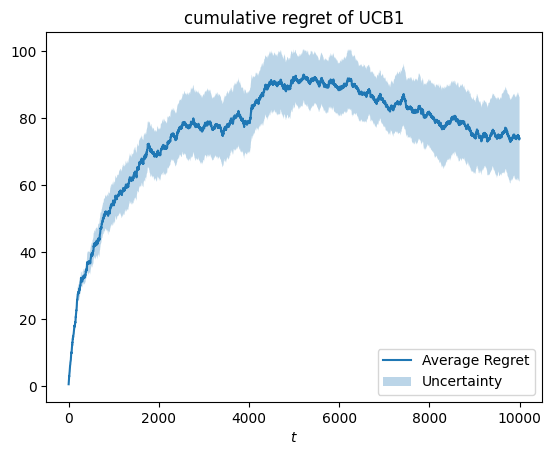

Text(0.5, 1.0, 'number of pulls per arm of UCB1')

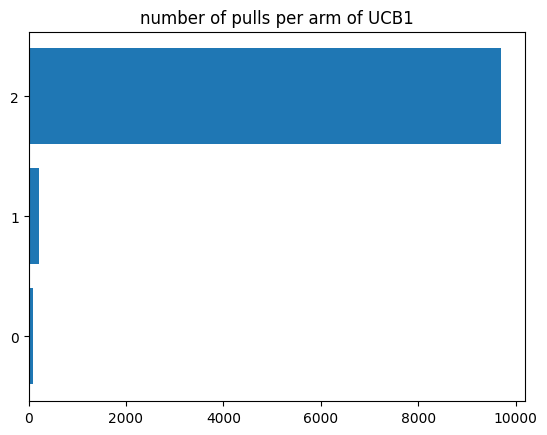

In [10]:
p = np.array([0.25, 0.5, 0.75])
T = 10000
expected_clairvoyant_rewards = np.repeat(p[best_action], T)

n_trials = 10

regret_per_trial = []

np.random.seed(seed)
for seed in range(n_trials):
    env = BernoulliEnvironment(p, T)
    ucb_agent = UCB1Agent(K, T)

    agent_rewards = np.array([])

    for t in range(T):
        a_t = ucb_agent.pull_arm()
        r_t = env.round(a_t)
        ucb_agent.update(r_t)

        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of UCB1')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
#plt.plot((0,T-1), (average_regret[0], average_regret[-1]), 'ro', linestyle="--")
plt.xlabel('$t$')
plt.legend()
plt.show()

plt.barh(y=['0','1','2'], width=ucb_agent.N_pulls)
plt.title('number of pulls per arm of UCB1')